## **0.0 Imports**

In [225]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import umap.umap_ as umap

### 0.1 Helper Functions

### 0.2 Load Dataset

In [179]:
# laod dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis=1)

In [180]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## **1.0 Descrição dos dados**

In [181]:
df1 = df_raw.copy()

### **1.1 Rename columns**

In [182]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns  = cols_new

### **1.2 Data dimensions**

In [183]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### **1.3 Data types**

In [184]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [185]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### **1.4 Check NA**

In [186]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### **1.5 Replace NA**

In [187]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [188]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### **1.6 Changes dTypes**

In [189]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [190]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### **1.7 Descriptive Statistics**

In [191]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

#### **1.7.1 Numerical Attributes**

In [192]:
# central tendency - mean, median
c1 = pd.DataFrame(num_attributes.apply(np.mean)).T
c2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - min, max, range, standard deviation, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.mean())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([c1, c2, d4, d1, d2, d3, d5, d6]).T.reset_index()
m.columns = ['attributes', 'mean', 'median', 'std', 'min','max','range','skew','kurtosis']
m

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,12.061303,5.00,248.693064,-80995.0,80995.0,80982.938697,0.182663,94317.563673
1,unit_price,3.460471,1.95,69.315077,0.0,38970.0,38966.539529,452.219019,246924.542988
2,customer_id,15287.690570,15152.00,1713.598197,12346.0,18287.0,2999.309430,0.029835,-1.179982


##### **1.7.1.1 <font color='red'> Numerical Attributes - Investigating** </font>

1. Quantidade negativa (pode ser devolução?)
2. Preço unitário igual a zero (pode ser promoção?)

#### **1.7.2 Categorical Attributes**

In [193]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [194]:
# invoice number with letter
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3654

In [195]:
# stock code with letter
len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

886

In [196]:
# stock code only letter
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].drop_duplicates()

45        POST
141          D
2239         M
157195    PADS
317507     DOT
317508    CRUK
Name: stock_code, dtype: object

## **2.0 Filtragem de Variáveis**

In [197]:
df2 = df1.copy()

In [198]:
df2.loc[df2['quantity'] < 0, :].sort_values(['customer_id', 'description']).head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346.0,United Kingdom
129743,C547388,21914,BLUE HARMONICA IN BOX,-12,2017-03-20,1.25,12352.0,Norway
129738,C547388,37448,CERAMIC CAKE DESIGN SPOTTED MUG,-12,2017-03-20,1.49,12352.0,Norway
129741,C547388,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,-12,2017-03-20,1.45,12352.0,Norway
129739,C547388,22784,LANTERN CREAM GAZEBO,-3,2017-03-20,4.95,12352.0,Norway
129742,C547388,22413,METAL SIGN TAKE IT OR LEAVE IT,-6,2017-03-20,2.95,12352.0,Norway
106394,C545329,M,Manual,-1,2017-02-27,280.05,12352.0,Norway
106395,C545329,M,Manual,-1,2017-02-27,183.75,12352.0,Norway
106397,C545330,M,Manual,-1,2017-02-27,376.50,12352.0,Norway
129740,C547388,22701,PINK DOG BOWL,-6,2017-03-20,2.95,12352.0,Norway


In [199]:
# ======= Numerical Attributes =======
# unit price
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code != [POST, M, D, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST','D','M','DOT','CRUK'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >  0, :]

In [200]:
df2_returns.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom


In [201]:
df2_purchase.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## **3.0 Feature Engineering**

In [202]:
df3 = df2_purchase.copy()

### **3.1 Feature Creation**

In [203]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [204]:
# Gross Revenue (Faturamento) quantity * price
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

In [205]:
# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

In [206]:
# Recency - Last day purchase
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
dtype: int64

In [207]:
# Frequency - Quantity 
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
dtype: int64

In [208]:
# Avg Ticket
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

In [209]:
# Number of returns
df_returns = df2_returns[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

In [210]:
df_ref

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850.0,5391.21,372,34,18.152222,1.0
1,13047.0,3232.59,56,9,18.904035,7.0
2,12583.0,6705.38,2,15,28.902500,2.0
3,13748.0,948.25,95,5,33.866071,0.0
4,15100.0,876.00,333,3,292.000000,3.0
...,...,...,...,...,...,...
4330,13436.0,196.89,1,1,16.407500,0.0
4331,15520.0,343.50,1,1,19.083333,0.0
4332,13298.0,360.00,1,1,180.000000,0.0
4333,14569.0,227.39,1,1,18.949167,0.0


## **4.0 EDA (Exploratory Data Analysis)**

In [211]:
df4 = df_ref.copy()

In [212]:
df4.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850.0,5391.21,372,34,18.152222,1.0
1,13047.0,3232.59,56,9,18.904035,7.0
2,12583.0,6705.38,2,15,28.902500,2.0
3,13748.0,948.25,95,5,33.866071,0.0
4,15100.0,876.00,333,3,292.000000,3.0


In [213]:
print('Quantidade de clientes: {}'.format(df4['customer_id'].count()))

Quantidade de clientes: 4335


## **5.0 Data Preparation**

In [214]:
df5 = df4.copy()

## **6.0 Feature Selection**

In [215]:
df6 = df5.copy()

## **7.0 Hyperparameter Fine Tuning**

In [216]:
X = df6.drop(columns=['customer_id'])

In [217]:
clusters = [2, 3, 4, 5, 6, 7]

### **7.1 Within-Cluster Sum of Square (WSS)**

Text(0.5, 1.0, 'WSS vs K')

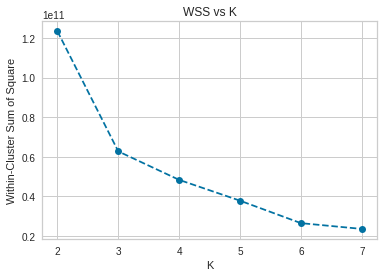

In [218]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    #model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')

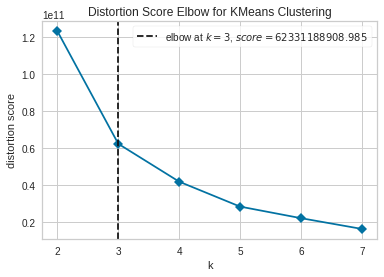

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [219]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

*WSS definiu K = 3*

### **7.2 Silhouette Score**

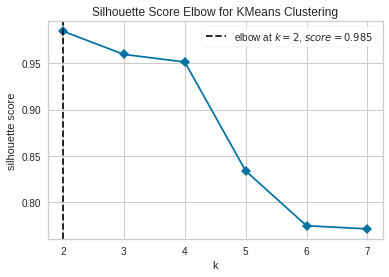

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [220]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

*Silhouette Score definiu K = 2*

### **7.3 Silhouette Analysis**

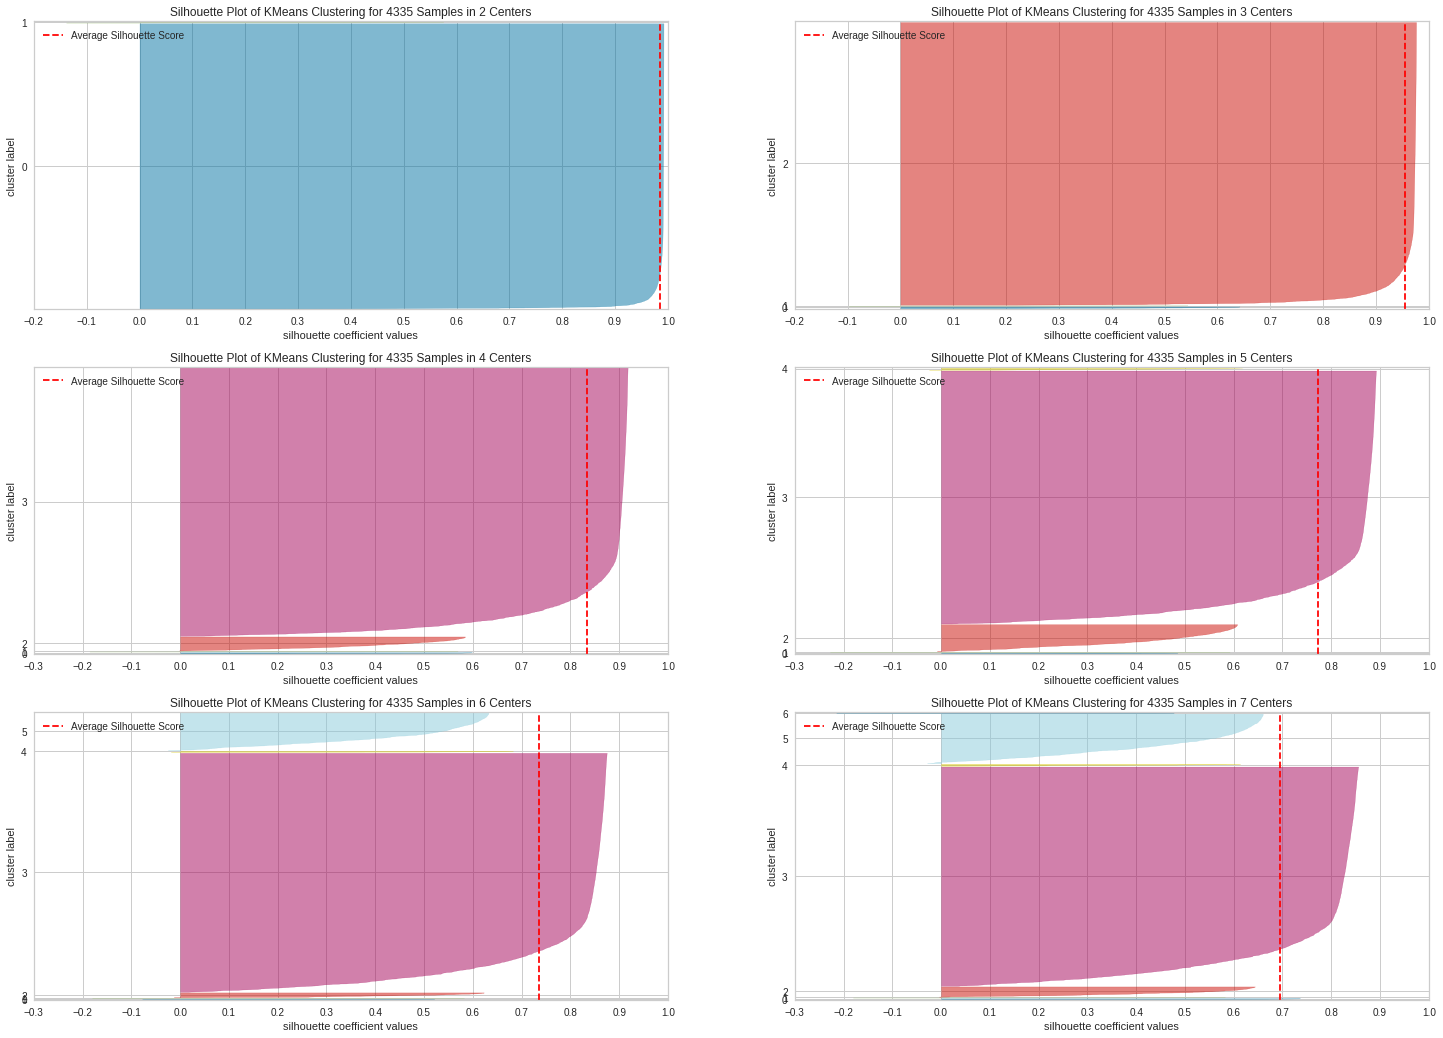

In [221]:
k = [2, 3, 4, 5, 6, 7]

fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

## **8.0 Model Training**

### **8.1 Models**

#### **8.1.1 K-Means**

In [222]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### **8.2 Cluster Validation**

In [226]:
# WSS (Within Cluster sum of square)
print('WSS: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS: 48318577038.17052
SS: 0.8331208470763639


## **9.0 Cluster Analysis**

In [227]:
df9 = df6.copy()
df9['cluster'] = labels

In [228]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850.0,5391.21,372,34,18.152222,1.0,2
1,13047.0,3232.59,56,9,18.904035,7.0,3
2,12583.0,6705.38,2,15,28.902500,2.0,2
3,13748.0,948.25,95,5,33.866071,0.0,3
4,15100.0,876.00,333,3,292.000000,3.0,3


### **9.1 Vizualizer Inspection**

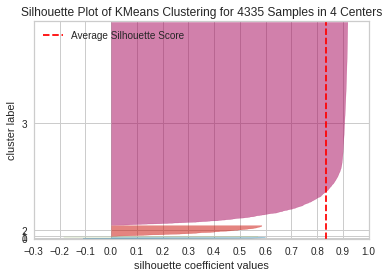

In [229]:
k = 4
km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### **9.2 2d Plot**

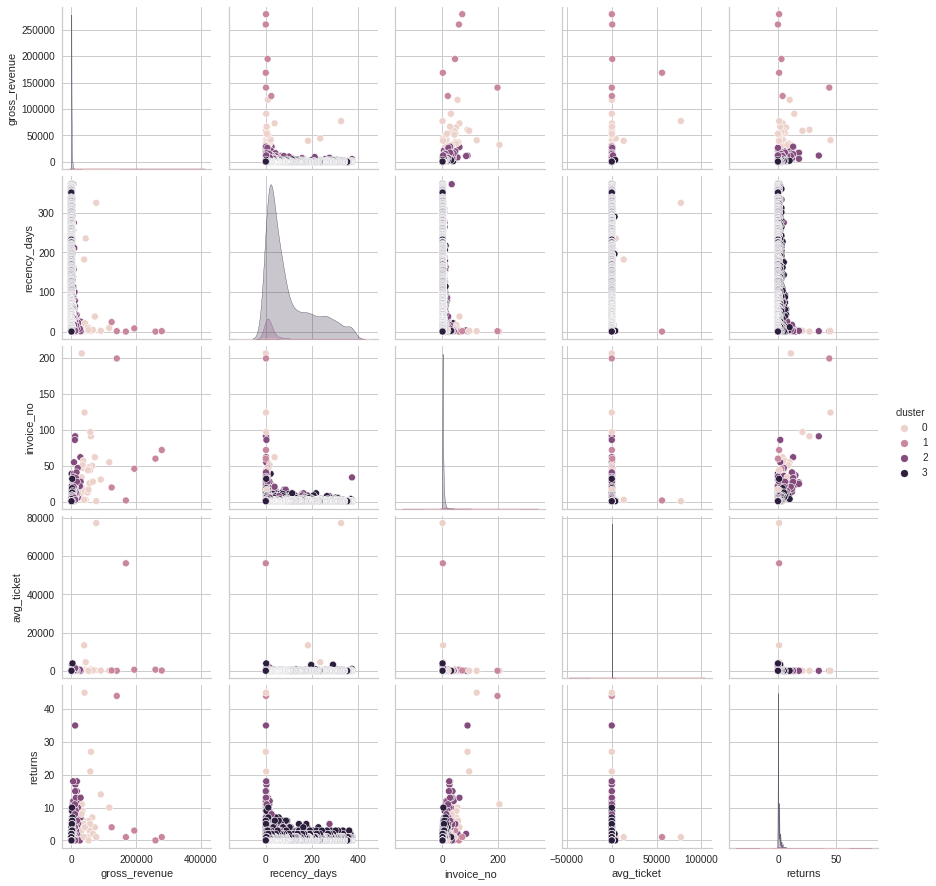

In [230]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### **9.3 UMAP**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

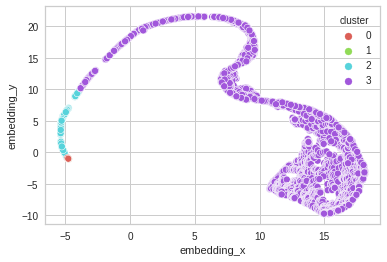

In [231]:
reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz)

### **9.4 Cluster Profile**

In [232]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100 * (df_cluster['customer_id']/df_cluster['customer_id'].sum())

# gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# invoice number
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Average Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

# Number of returns
df_returns = df9[['returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

df_cluster.sort_values('perc_customers')

,cluster,customer_id,perc_customers,gross_revenue,recency_days,invoice_no,avg_ticket,returns
1,1,6,0.138408,194472.310000,5.666667,66.500000,9612.036939,8.833333
0,0,25,0.576701,53596.348800,35.640000,47.160000,3955.189057,7.840000
2,2,214,4.936563,9650.407477,21.303738,17.289720,73.737961,3.953271
3,3,4090,94.348328,1025.913905,96.416626,3.212225,29.888764,0.552078


## **10.0 Deploy to Production**